## Drone Assisted Emergency Medical Response

***This case uses synthetic data throughout.***

To simplify things a bit, let's say the region we care about (Ontario) is a square with coordinates going from $[0, 1]$.  We divy up the square into $49$ zones, and we assume the time to get to a cardiac event is essentially the same as the time to get to the zone center.  There are 11 potential depot locations.  We have data on the number of cardiac arrest events at different zone centers over the past year, and, from our data science team, their best estimate of the rate of incidents per per year for each zone.  

The cell below loads up this data and makes a small plot to give you a sense of the data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gurobipy import Model, GRB, quicksum

#load historical_event_rates.csv as a numpy array
#the way this was stored,teh first two columns describe the zone center, 
# third colum is the number of events in that zone over last year
# the fourth column is a precise estimate of the rate of events per year (fit with some statistical model)
historical_event_counts = np.loadtxt('historical_event_rates.csv', delimiter=',', skiprows=1)
zone_centers = historical_event_counts[:, :2]  # first two columns are zone centers
event_rates = historical_event_counts[:, 3]  # fourth column is our best estimate of event_rates

#load depot_locations.csv as a numpy array
depot_locations = np.loadtxt('depot_locations.csv', delimiter=',', skiprows=1)

#load distance_matrix.csv as a numpy array
distance_matrix = np.loadtxt('distance_matrix.csv', delimiter=',', skiprows=1)

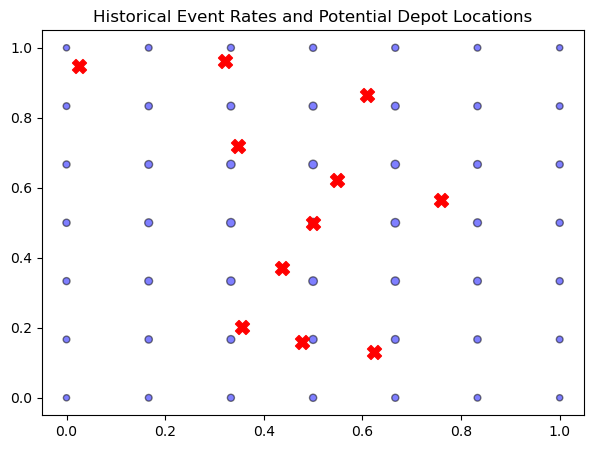

In [2]:
#create a plot of the zone_centers, where the size of each point is proportional to the event_counts
plt.figure(figsize=(7, 5))
plt.scatter(zone_centers[:, 0], zone_centers[:, 1], s=event_rates * 20, alpha=0.5, c='blue', edgecolors='k')
# Add depot locations to the plot
plt.scatter(depot_locations[:, 0], depot_locations[:, 1], s=100, c='red', marker='X', label='Depots')
plt.title('Historical Event Rates and Potential Depot Locations')
plt.show()


### Towards a formulation
We have some problem data:
 - A drone can travel the length of region (i.e. a distance of $1$) in 1 minute
 - After a lot of internal debate, Decion-makers want to open 5 drone depots.

Using this information, formulate and solve a mixed-binary, linear optimization problem to determine which depots to open

In [3]:
drone_speed = 1  #in units of length of region/minute
max_depots = 5  # maximum number of depots we can open is the number of depot locations available
 
m = Model("Emergency Response Optimization")



Set parameter Username
Set parameter LicenseID to value 2609347
Academic license - for non-commercial use only - expires 2026-01-13


## Plot the routing plan

NameError: name 'num_zones' is not defined

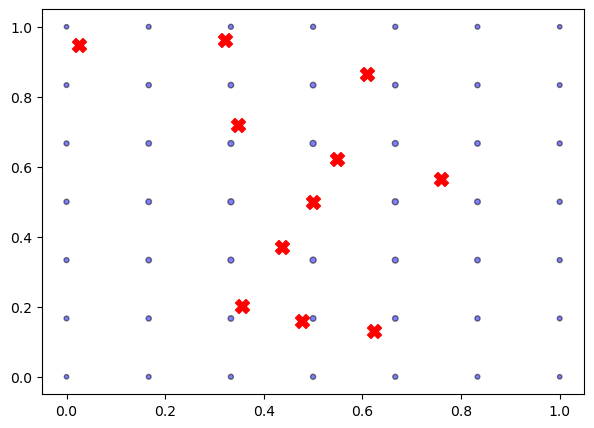

In [4]:
#make a plotof the zones served by each depot
plt.figure(figsize=(7, 5))
# Plot zone centers
plt.scatter(zone_centers[:, 0], zone_centers[:, 1], s=event_rates * 10, alpha=0.5, c='blue', edgecolors='k', label='Zone Centers')
# Plot depot locations
plt.scatter(depot_locations[:, 0], depot_locations[:, 1], s=100, c='red', marker='X', label='Depots')
# Plot lines from depots to zones they serve
for i in range(num_zones):
    for j in range(num_depots):
        if x[i, j].X > 0.5:  # If the zone is served by this depot
            plt.plot([zone_centers[i, 0], depot_locations[j, 0]], [zone_centers[i, 1], depot_locations[j, 1]], 'k--', alpha=0.5)
plt.title('Zones Served by Depots')
plt.legend()
plt.show()

### Simulating to understand the robustness of the solution

Our choice of depots depends on the estimated rate of incidents in each zone.  But these rates are estimated.  Might small errors in those estimated rates manifest as large increases in response time?  

You consult your data science friend.  They suggest that since you're not very sure about the rates, you might perturb the estimated rates by a random amount that's about 5\% of the current value.  Your friend suggest by multiplying by a random number chosen between .95 and 1.05

 Run a simulation where you perturb the rates of incidents randomly as suggested above and compute a histogram for the total response time in the system.

In [ ]:
noise_frac = .15
numReps = 1000
tot_time = np.zeros(numReps)
new_lambdas = np.zeros(num_zones)


## The number of depots

The American Heart Association recommends that an AED be placed on a patient who has a cardiac incident within 5 minutes.  How many depots would you need to accomplish this?